# Microkinetic modelling of  multi-electron transfer electrocatalyis
$$\require{mhchem}$$
Author: Joel W. Ager (jwager@lbl.gov), [Group website](http://ager.mse.berkeley.edu), [github](https://github.com/joelager)

Adapts analyses in 
>Koper, M. T. M.; Jansen, A. P. J.; van Santen, R. A.; Lukkien, J. J.; Hilbers, P. A. J. Monte Carlo Simulations of a Simple Model for the Electrocatalytic CO Oxidation on Platinum. [*J. Chem. Phys.* **1998**, 109, 6051–6062](http://aip.scitation.org/doi/10.1063/1.477230).

The paper is one of a very few examples of which I am aware of applying a stochastic analysis to electrochemistry: in it, a mean field model is compared to a lattice Monte Carlo simulation for a model reaction, CO stripping from Pt. In this notebook, the mean field model is coded.  

Koper and co-workers consider the two steps of CO oxidation on Pt: 

$$\ce{H2O + $*$  <=> OH_{ads} + H+ + e-}\tag{1}$$

$$\ce{CO_{ads} + OH_{ads}  -> CO2 + H+ + e- + 2$*$}\tag{2}$$

In their analysis, reaction (1) will be considered reversible but reaction (2) will be irreversible (i.e. there will not a be way to repopulate the surface with CO). 

Rate constants are:

$$k_1 = k^0_1 \exp(\alpha_1 e_0 E / k_B T) $$

$$k_{-1} = k^0_{-1} (-(1-\alpha_1) \exp(e_0 E / k_B T) $$

$$k_2  = k^0_2  \exp(\alpha  e_0 E / k_B T) $$

where $e_0$ is elementary charge and $E$ is the applied potential. Both transfer coefficients $\alpha$ will be set to 0.5. 

The reaction rates $v_i$ are:

$$v_1 = \Gamma_s k_1 (1-\theta_{OH} - \theta_{CO} ) $$

$$v_{-1} = \Gamma_s k_{-1} \theta_{OH}  $$

$$v_2  = \Gamma_s Z k  \theta_{OH}  \theta_{CO}  $$

where $\Gamma_s$ is the density of surface sites (cm<sup>-2</sup>) and $Z$ is the number of nearest neighbor sites, which is 4 on the square lattice used.  Total current density is:

$$ j = e_0 (v_1 - v_{-1} + v ) $$

The time evolution of the mean field coverages $\theta_{CO}$ and $\theta_{OH}$ are governed by two ODEs:

$$\Gamma_s \frac{d \theta_{OH}}{dt} = v_1-v_{-1} -v  $$
$$\Gamma_s \frac{d \theta_{CO}}{dt} = -v  $$

## Initialize

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Importing the ODE solver
from scipy.integrate import solve_ivp   # new solver to use, odeint will be deprecated

In [2]:
# SI Base Units
meter, sec, mol, coul, volt, kelvin, kg = 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

In [3]:
## Derived units and physical constants
amp    = coul*sec**-1 
joule  = kg * meter**2 * sec**-2

cm     = 1e-2*meter

mA     = 10**-3*amp 
μA     = 10**-6*amp
nA     = 1e-9*amp
pA     = 1e-12*amp

mV     = 1e-3*volt

liter  = 1000*cm**3 
molar  = mol/liter 
mM     = 10**-3*molar 

## Physical constants
R      = 8.3144598                # in SI units, J mol-1 K-1
q      = 1.60217662*10**-19*coul  # Elementary charge
NA     = 6.02214076*10**23        # Avogadro number
F      = NA*q                     # Faraday constant

## Other units
eV     = 1.602176634*1e-19*joule
meV    = 1e-3*eV
kB     = R/NA

In [4]:
# Constants to be used throughout the calcuation
T = 300*kelvin

α_1 = 0.5                    # Transfer coeffients
α_2 = 0.5

Z = 4.0                      # Number of nearest neighbors
Γ_sites = 1.32e15*cm**-2     # Density of surface atoms

# Classes and functions
It is convenient to use python classes to to contain the rate constants to simplify changing these parameters to compare different cases. 

Might need to add a class for initial conditions. 

## Electrochemical model

In [5]:
# alphas are constants for now

class EC_model_params():
    """
    Default is the FAST case from Koper paper
    """
    # For OH- adsorption and desorption
    k1zero=0.02*sec**-1 
    kminus1zero=1e4*sec**-1 
    # For the *CO + *OH -> CO2(g)
    k2zero=0.8234*sec**-1
    
case_FAST = EC_model_params()

case_SLOW = EC_model_params()
case_SLOW.k2zero = 0.8234e-5

In [6]:
# Rate constants
def k1(E, EC_model_params):   
    return EC_model_params.k1zero*np.exp( (α_1*q*E)/(kB*T) )

def kminus1(E, EC_model_params):   
    return EC_model_params.kminus1zero*np.exp( -((1-α_1)*q*E)/(kB*T) )

def k2(E, EC_model_params):   
    return EC_model_params.k2zero*np.exp( (α_1*q*E)/(kB*T) )

# Currents
def J(E, θ_OH, θ_CO, EC_model_params):
    v_1 = k1 (E, EC_model_params)*(1 - θ_OH - θ_CO)
    v_minus1 = kminus1 (E, EC_model_params)*θ_OH
    v_2  = Z*k2(E, EC_model_params)*θ_OH*θ_CO
    return (q*Γ_sites)*(v_1 - v_minus1 + v_2 )

Now make the pontential dependence rate constants functions of this class

## Scan parameters

## CV scan function
In Fig. 1 of paper, scan goes from 0.1 to 0.5 V and back again.  

In [7]:
# Function to construct a single CV scan
# Might put these into a class as well eventually 
Estart =  0.1 *volt
Efinish = 0.5 *volt
sweep_rate = 50.0 *mV*sec**-1
cycle_time = 2.0 * (Efinish-Estart)/sweep_rate 

def E_CV(t):
    potential = np.piecewise(t, 
                             [t < 0 , 
                              t >= 0 and t < cycle_time/2.0, 
                              t > cycle_time/2. and t < cycle_time ,
                              t >= cycle_time], 
                             [Estart, 
                              Estart + t*sweep_rate, 
                              Efinish - (t - cycle_time/2.0) *sweep_rate,
                              Estart])
    return potential.item(0)

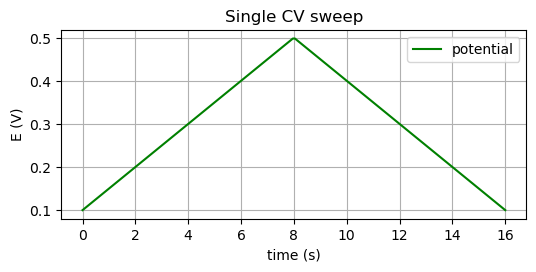

In [8]:
# Checking the CV sweep
t_plot = np.linspace(0,cycle_time,200)

plt.figure(figsize=(6,2.5), dpi=100)
plt.title('Single CV sweep')
plt.plot(t_plot, [E_CV(t) for t in t_plot], 'g', label = "potential") 
plt.xlabel("time (s)")
plt.ylabel("E (V)")
plt.legend(loc='best')
plt.grid()
plt.show()

## ODEs and solution

In [9]:
# Sets up the function to be called by solve_ivp

def CV_scan_ODEs(t,z,EC_model_params):
    θ_OH = z[0]
    θ_CO = z[1]
    
    dθ_OHdt = k1(E_CV(t), EC_model_params)*(1 - θ_OH - θ_CO) - \
              kminus1(E_CV(t), EC_model_params)*θ_OH - \
              Z*k2(E_CV(t), EC_model_params)*θ_OH*θ_CO
    
    dθ_COdt = -Z*k2(E_CV(t),EC_model_params)*θ_OH*θ_CO
    dzdt = [dθ_OHdt, dθ_COdt]
    return dzdt

def fixed_E_ODEs(t, z, E, EC_model_params):
    θ_OH = z[0]
    θ_CO = z[1]
    
    dθ_OHdt = k1(E, EC_model_params)*(1 - θ_OH- θ_CO) - \
              kminus1(E, EC_model_params)*θ_OH - \
              Z*k2(E, EC_model_params)*θ_OH*θ_CO
    
    dθ_COdt = -Z*k2(E, EC_model_params)*θ_OH*θ_CO
    dzdt = [dθ_OHdt, dθ_COdt]
    return dzdt

# CV sweeps

CV scan initiated:
OH coverage  = 0.0
CO Coverage = 0.75


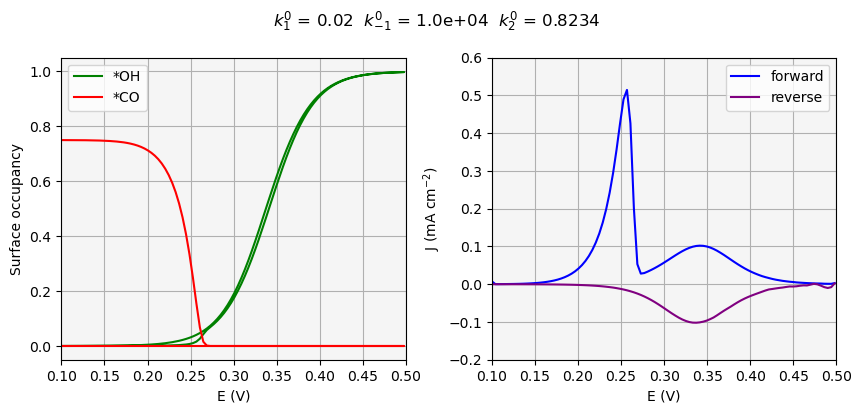

In [17]:
# Sweep parameters for Koper Figure 1
Estart =  0.1 *volt              # E = 0.3 was largest driving force in Figure 1
Efinish = 0.5 *volt              # Larger driving forces lead to huge currents. 
sweep_rate = 50.0 *mV*sec**-1
cycle_time = 2.0 * (Efinish - Estart)/sweep_rate 

# time points for ODE integration
t_CV = np.linspace(0, cycle_time, 200)


# Intial conditions - nothing will happen if the surface is full
θ_OH_init = 0.00
θ_CO_init = 0.75        # In figure 1 of paper, 0.99, 0.75, and 0.50 are considered

# Boundary conditions for odeint
print('CV scan initiated:')
print('OH coverage  =', θ_OH_init)
print('CO Coverage =', θ_CO_init)

# solve ODE
case = case_FAST
sol_CV_2 = solve_ivp(lambda t,y: CV_scan_ODEs(t,y,case), 
                     [0, cycle_time], 
                     [θ_OH_init, θ_CO_init], 
                     t_eval=t_CV, 
                     method='Radau')
θ_OH_2 = sol_CV_2.y[0]
θ_CO_2 = sol_CV_2.y[1]

# Compute the E values for the CV plot 
E_CV_plot = np.array([E_CV(t) for t in t_CV])

# Compute Current densities for the plot - loop for the moment
J_CV_plot_2 = np.empty_like(t_CV)
for i, (E,θ_OH, θ_CO) in enumerate(zip(E_CV_plot, θ_OH_2, θ_CO_2)):
    J_CV_plot_2[i] = J(E, θ_OH, θ_CO, case_FAST)

    
# Display the results
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4), dpi=100)

# Note use of {{}} to fix issue with parsing the title string 
fig.suptitle('$k_1^0$ = {}  $k_{{-1}}^0$ = {:.1e}  $k ^0_2$ = {}'.format(case_FAST.k1zero, 
                                                                      case_FAST.kminus1zero,
                                                                      case_FAST.k2zero), y =1.0)  
# LH figure
ax1.plot(E_CV_plot, θ_OH_2, 'g', label = "*OH") 
ax1.plot(E_CV_plot, θ_CO_2, 'r', label = "*CO")
# can also graph vacancies but makes the figure a bit messy
# ax1.plot(E_CV_plot,1- z[:,1]-z[:,0], 'b', label = "*")
ax1.legend(loc='best')
ax1.grid(True)
ax1.set_xlabel("E (V)")
ax1.set_xlim(Estart,Efinish)
ax1.set_ylabel("Surface occupancy")
ax1.set_ylim(-0.05,1.05)
ax1.set_facecolor('whitesmoke')
# RH figure
ax2.plot(np.split(E_CV_plot,2)[0], np.split(J_CV_plot_2,2)[0]/(mA*cm**-2),'blue', label='forward')
ax2.plot(np.split(E_CV_plot,2)[1], np.split(J_CV_plot_2,2)[1]/(mA*cm**-2),'purple', label='reverse')
ax2.legend(loc='best')
ax2.grid(True)
ax2.set_xlabel("E (V)")
ax2.set_xlim(Estart,Efinish)
ax2.set_ylabel("J (mA cm$^{-2}$)")
ax2.set_ylim(-0.2,0.6)
ax2.set_facecolor('whitesmoke')

fig.subplots_adjust(wspace=0.25)

plt.show()

Compare the rate constants. Forward and reverse rates of (1) are the same at ~0.33 V. 

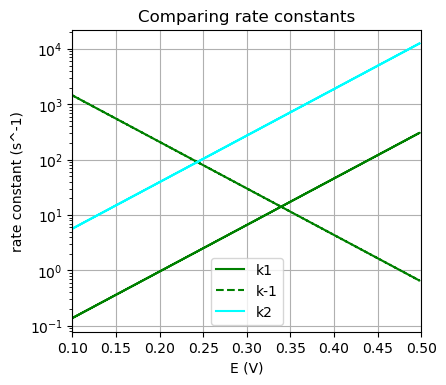

In [11]:
plt.figure(figsize=(4.5,4), dpi=100)
plt.title('Comparing rate constants')

plt.semilogy(E_CV_plot, k1(E_CV_plot, case_FAST),'g', label='k1')
plt.semilogy(E_CV_plot, kminus1(E_CV_plot, case_FAST),'g--', label='k-1')
plt.semilogy(E_CV_plot, k2(E_CV_plot, case_FAST),'cyan' ,label='k2')

plt.legend(loc='best')

plt.xlabel("E (V)")
plt.xlim(0.1,0.5)
plt.ylabel("rate constant (s^-1)")
plt.xlim(0.1,0.5)

plt.grid()
plt.show()

## CVs in Figures 1 and 6

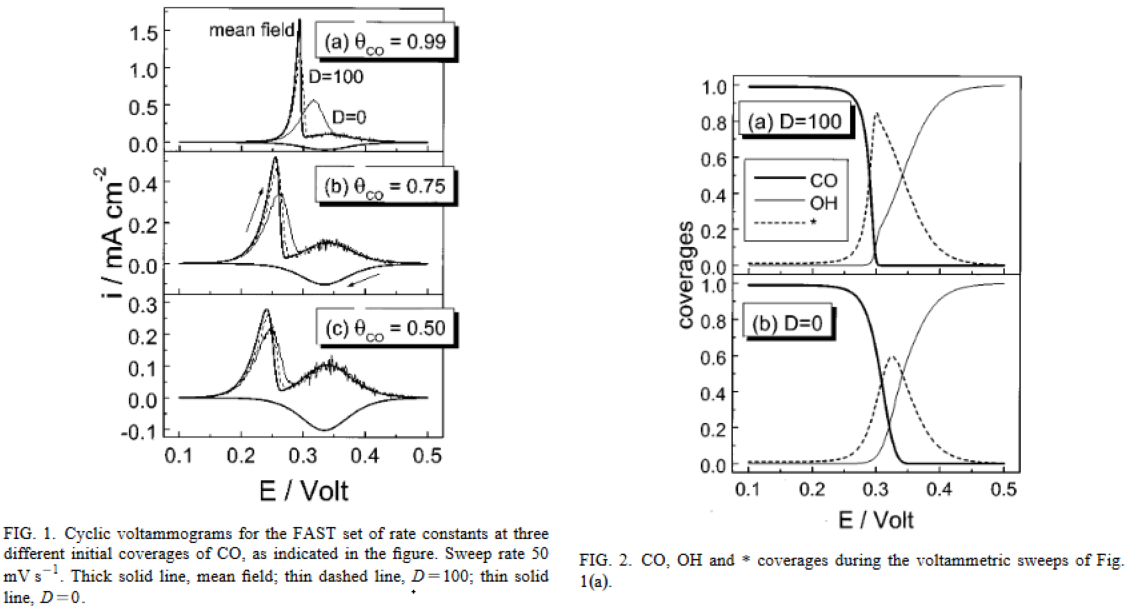

The mean field model can be compared to the D = 100 case in Fig. 2.  

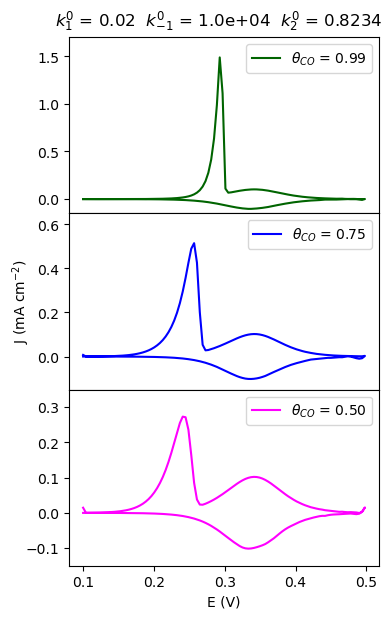

In [12]:
# Do the other two cases 
# Start with 99% coverage
sol_CV_1 = solve_ivp(lambda t,y: CV_scan_ODEs(t,y,case), [0, cycle_time],
                     [0.00, 0.99], t_eval=t_CV, method='Radau')
θ_OH_1 = sol_CV_1.y[0]
θ_CO_1 = sol_CV_1.y[1]

# Compute Current densities for the plot - loop for the moment
J_CV_plot_1 = np.empty_like(t_CV)
for i, (E,θ_OH, θ_CO) in enumerate(zip(E_CV_plot, θ_OH_1, θ_CO_1)):
    J_CV_plot_1[i] = J(E, θ_OH, θ_CO, case_FAST)
    
# Already did 75%. So do 50% here.
sol_CV_3 = solve_ivp(lambda t,y: CV_scan_ODEs(t,y,case), [0, cycle_time],
                     [0.00, 0.50], t_eval=t_CV, method='Radau')
θ_OH_3 = sol_CV_3.y[0]
θ_CO_3 = sol_CV_3.y[1]

# Compute Current densities for the plot - loop for the moment
J_CV_plot_3 = np.empty_like(t_CV)
for i, (E,θ_OH, θ_CO) in enumerate(zip(E_CV_plot, θ_OH_3, θ_CO_3)):
    J_CV_plot_3[i] = J(E, θ_OH, θ_CO, case_FAST)

# Make the figure
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(4,7), dpi=100, sharex=True)
fig.suptitle('$k_1^0$ = {}  $k_{{-1}}^0$ = {:.1e}  $k ^0_2$ = {}'.format(case_FAST.k1zero, 
                                                                      case_FAST.kminus1zero,
                                                                      case_FAST.k2zero), y =0.92)

ax1.plot(E_CV_plot, J_CV_plot_1/(mA*cm**-2),'darkgreen', label='$\\theta_{CO}$ = 0.99')
ax1.set_ylim(-0.15, 1.7)
ax1.legend()

ax2.plot(E_CV_plot, J_CV_plot_2/(mA*cm**-2),'blue', label='$\\theta_{CO}$ = 0.75')
ax2.set_ylim(-0.15, 0.65)
ax2.set_ylabel("J (mA cm$^{-2}$)")
ax2.legend()

ax3.plot(E_CV_plot, J_CV_plot_3/(mA*cm**-2),'magenta', label='$\\theta_{CO}$ = 0.50')
ax3.set_ylim(-0.15, 0.35)
ax3.legend()

ax3.set_xlabel("E (V)")

fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)

Perfect agreement with paper. CO oxidation feature is later and sharper at higher initial coverages. The $\ce{OH_{ads}}$ reduction feature is similar for all of them as the surface coverage goes to close to 100% at the positive end of the sweep. 

# Potential step

## E = 0.275 for comparison to paper

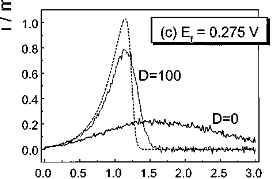

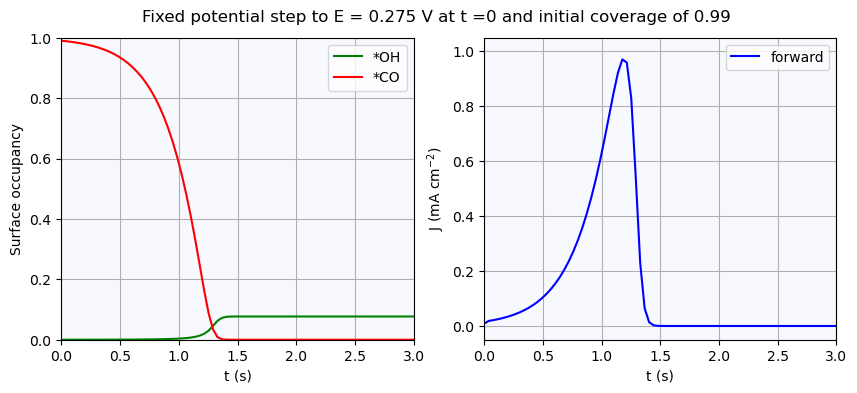

In [19]:
t_final = 3.0
t_span = np.linspace(0.0, t_final, 80)

E = 0.275 # For comparison to Figure 5

case = case_FAST
sol = solve_ivp(lambda t,y: fixed_E_ODEs(t,y ,E, case),
                [0,t_final], 
                [0.00, 0.99], 
                t_eval=t_span, 
                method='LSODA')
θ_OH_sol = sol.y[0]
θ_CO_sol = sol.y[1]

# Current density
J_Estep_plot = np.empty_like(t_span)
for i, (θ_OH, θ_CO) in enumerate(zip(θ_OH_sol, θ_CO_sol)):
    J_Estep_plot[i] = J(E, θ_OH, θ_CO, case_FAST)

# Display the results
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4), dpi=100)

# Note use of {{}} to fix issue with parsing the title string 
fig.suptitle('Fixed potential step to E = 0.275 V at t =0 and initial coverage of 0.99', y=0.95)  
# LH figure
ax1.plot(t_span, θ_OH_sol, 'g', label = "*OH") 
ax1.plot(t_span, θ_CO_sol, 'r', label = "*CO")
# can also graph vacancies but makes the figure a bit messy
# ax1.plot(E_CV_plot,1- z[:,1]-z[:,0], 'b', label = "*")
ax1.legend(loc='best')
ax1.grid(True)
ax1.set_xlabel("t (s)")
ax1.set_xlim(0, t_final)
ax1.set_ylabel("Surface occupancy")
ax1.set_ylim(0,1.)
ax1.set_facecolor('ghostwhite')
# RH figure
ax2.plot(t_span, J_Estep_plot/(mA*cm**-2),'blue', label='forward')
ax2.legend(loc='best')
ax2.grid(True)
ax2.set_xlabel("t (s)")
ax2.set_xlim(0, t_final)
ax2.set_ylabel("J (mA cm$^{-2}$)")
ax2.set_ylim(-0.05, 1.05)
ax2.set_facecolor('ghostwhite')


plt.show()

Good agreement with paper. 

## E = 0.35 V for comparison to Zacros

Initial work in `Zacros` was done at E = 0.35 V. This is a good potential because the $\ce{OH_{ads}}$ coverage goes to about 0.60.

Actually, we could look at comparison of MFA to KMC for a number of potentials as shown here, varying the diffusion parameter $D$.

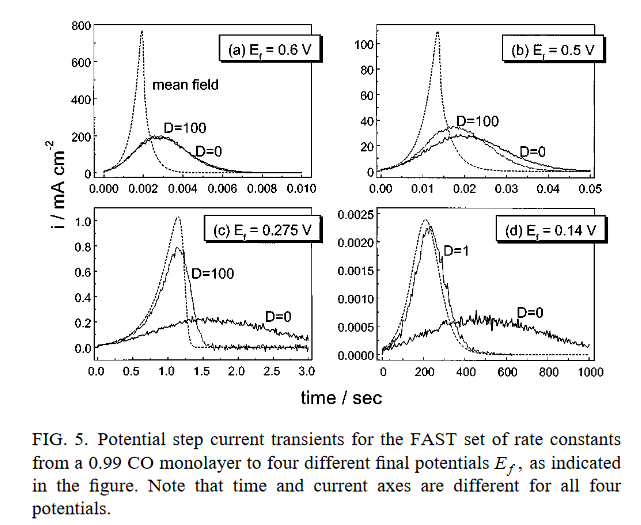

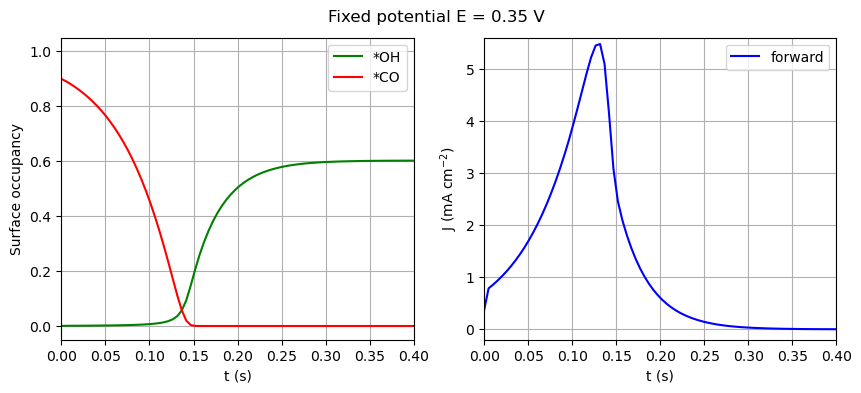

In [14]:
t_final = 0.4
t_span = np.linspace(0.0, t_final, 80)

E = 0.35

case = case_FAST
sol = solve_ivp(lambda t,y: fixed_E_ODEs(t,y ,E, case),
                [0,t_final], 
                [0.00, 0.90], 
                t_eval=t_span, 
                method='LSODA')
θ_OH_sol = sol.y[0]
θ_CO_sol = sol.y[1]

# Current density
J_Estep_plot = np.empty_like(t_span)
for i, (θ_OH, θ_CO) in enumerate(zip(θ_OH_sol, θ_CO_sol)):
    J_Estep_plot[i] = J(E, θ_OH, θ_CO, case_FAST)

# Display the results
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4), dpi=100)

# Note use of {{}} to fix issue with parsing the title string 
fig.suptitle('Fixed potential E = 0.35 V', y=0.95)  
# LH figure
ax1.plot(t_span, θ_OH_sol, 'g', label = "*OH") 
ax1.plot(t_span, θ_CO_sol, 'r', label = "*CO")
# can also graph vacancies but makes the figure a bit messy
# ax1.plot(E_CV_plot,1- z[:,1]-z[:,0], 'b', label = "*")
ax1.legend(loc='best')
ax1.grid(True)
ax1.set_xlabel("t (s)")
ax1.set_xlim(0, t_final)
ax1.set_ylabel("Surface occupancy")
ax1.set_ylim(-0.05,1.05)
# RH figure
ax2.plot(t_span, J_Estep_plot/(mA*cm**-2),'blue', label='forward')
ax2.legend(loc='best')
ax2.grid(True)
ax2.set_xlabel("t (s)")
ax2.set_xlim(0, t_final)
ax2.set_ylabel("J (mA cm$^{-2}$)")
ax2.set_ylim(-0.2,5.6)

plt.show()